In [1]:
%pip install wfdb


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
import os
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [37]:
import ast

In [38]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [39]:
path = "/Users/annaorlova/Desktop/ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"

In [40]:
sampling_rate = 100 

In [41]:
import os

if os.path.exists(path):
    print(f"Путь '{path}' найден!")
else:
    print(f"Путь '{path}' не найден. Проверьте корректность пути.")


Путь '/Users/annaorlova/Desktop/ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/' найден!


In [42]:
try:
    with open(path + 'ptbxl_database.csv', 'r') as file:
        print("Файл открыт успешно.")
except PermissionError as e:
    print(f"Ошибка доступа: {e}")

Файл открыт успешно.


In [43]:

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id') ## взять парочку и запустить с ними
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [44]:
sample_size = 2
Y_sample = Y.head(sample_size)

In [45]:
#signal data
X_sample = load_raw_data(Y_sample, sampling_rate, path)

#diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [46]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

## Visualization

In [14]:
Y_sample['diagnostic_superclass'] = Y_sample.scp_codes.apply(aggregate_diagnostic)

/var/folders/yh/__krj9vj03703dshgqrk6hqm0000gn/T/ipykernel_8342/3155120567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_sample['diagnostic_superclass'] = Y_sample.scp_codes.apply(aggregate_diagnostic)


In [15]:
import matplotlib.pyplot as plt

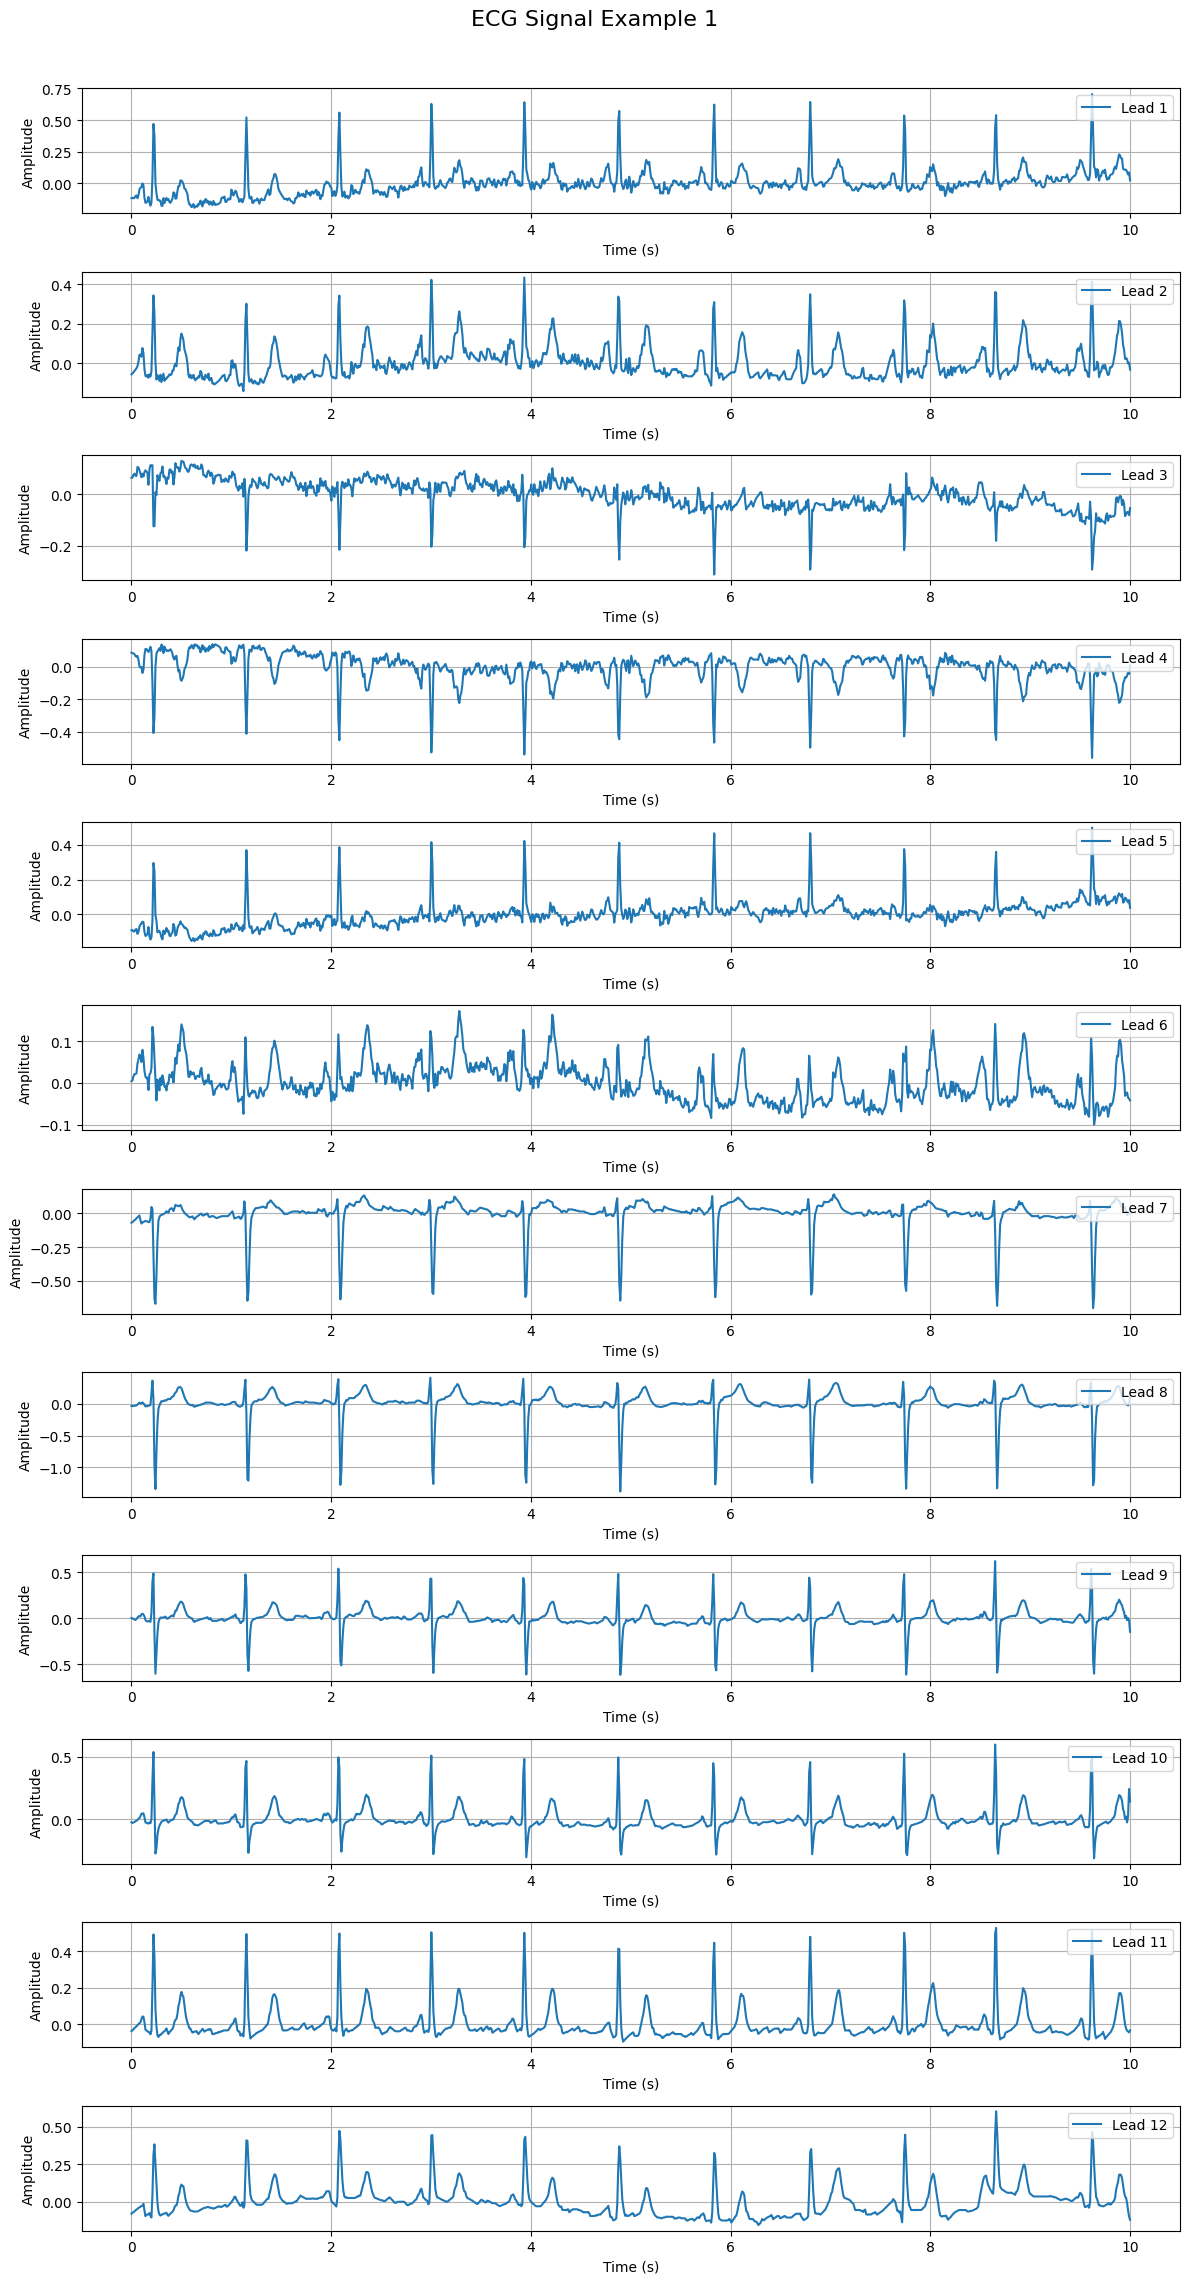

In [16]:
def plot_ecg(signal, sampling_rate, title="ECG Signal", leads=12):

    time = np.linspace(0, signal.shape[0] / sampling_rate, signal.shape[0])

    plt.figure(figsize=(12, 2 * leads))
    for i in range(leads):
        plt.subplot(leads, 1, i + 1)
        plt.plot(time, signal[:, i], label=f"Lead {i+1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend(loc="upper right")
        plt.grid()
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

example_index = 0
example_signal = X_sample[example_index]

plot_ecg(example_signal, sampling_rate, title=f"ECG Signal Example {example_index+1}")

## Dataframe for training 

In [47]:
import pandas as pd
import os
import ast

base_path = "/Users/annaorlova/Desktop/ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
records_path = os.path.join(base_path, "records100")
database_path = os.path.join(base_path, "ptbxl_database.csv")
scp_statements_path = os.path.join(base_path, "scp_statements.csv")

Y = pd.read_csv(database_path, index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval) 


agg_df = pd.read_csv(scp_statements_path, index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  


def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key]['diagnostic_class'])
    return list(set(tmp))


Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)


def get_record_path(filename, records_path):
    return os.path.join(records_path, filename)


Y['path_to_record'] = Y['filename_lr'].apply(lambda x: get_record_path(x, records_path))


diagnosis_dummies = Y['diagnostic_superclass'].explode().str.get_dummies().groupby(level=0).max()


df = pd.concat([Y[['path_to_record']], diagnosis_dummies], axis=1)


df.reset_index(inplace=True)
df.rename(columns={'ecg_id': 'patient_id'}, inplace=True)


print(df.head())


   patient_id                                     path_to_record  CD  HYP  MI  \
0           1  /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0   
1           2  /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0   
2           3  /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0   
3           4  /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0   
4           5  /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0   

   NORM  STTC  
0     1     0  
1     1     0  
2     1     0  
3     1     0  
4     1     0  


In [48]:
import pandas as pd
import numpy as np
import os
import ast

base_path = "/Users/annaorlova/Desktop/ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
records_path = os.path.join(base_path, "records100")
database_path = os.path.join(base_path, "ptbxl_database.csv")
scp_statements_path = os.path.join(base_path, "scp_statements.csv")

Y = pd.read_csv(database_path, index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval) 

agg_df = pd.read_csv(scp_statements_path, index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key]['diagnostic_class'])
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)

def get_record_path(filename, records_path):
    return os.path.join(records_path, filename + ".hea")


#Y['path_to_record'] = Y['filename_lr'].apply(lambda x: get_record_path(x, records_path))
Y['path_to_record'] = Y['filename_lr'].apply(lambda x: os.path.join(base_path, x))


diagnosis_dummies = Y['diagnostic_superclass'].explode().str.get_dummies().groupby(level=0).max()


df = pd.concat([Y[['path_to_record']], diagnosis_dummies], axis=1)


print(df.head())


                                           path_to_record  CD  HYP  MI  NORM  \
ecg_id                                                                         
1       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   
2       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   
3       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   
4       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   
5       /Users/annaorlova/Desktop/ecg/ptb-xl-a-large-p...   0    0   0     1   

        STTC  
ecg_id        
1          0  
2          0  
3          0  
4          0  
5          0  


In [49]:
sum = np.sum(df['NORM'])
sum

9514

In [50]:
sum = np.sum(df['CD'])
sum

4898

In [51]:
import pandas as pd
import numpy as np
import os
import wfdb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [52]:
def load_ecg_signal(record_path):
    try:
        record = wfdb.rdrecord(record_path) 
        signal = record.p_signal[:, 0]       
        return signal
    except Exception as e:
        print(f"Ошибка при загрузке записи {record_path}: {e}")
        return None


In [53]:
X = []
y = []

for _, row in df.iterrows():
    try:
        record = wfdb.rdrecord(row['path_to_record'])
        
        signal = record.p_signal
        
        X.append(signal)
        
        y.append(row[['CD', 'HYP', 'MI', 'NORM', 'STTC']].values.astype(int))
    except Exception as e:
        print(f"Ошибка при чтении файла {row['path_to_record']}: {e}")


X = np.array(X) 
y = np.array(y) 


print(f"Размерность X: {X.shape}")
print(f"Размерность y: {y.shape}")


Размерность X: (21799, 1000, 12)
Размерность y: (21799, 5)


## Dataset

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np


In [55]:
import torch.nn.functional as F


In [56]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [57]:
pip install iterative-stratification


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# Создаём стратифицированное разбиение
skf = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Генерируем индексы для разбиения
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break  # Берем только одно разбиение

print(f"Размерность X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Размерность y_train: {y_train.shape}, y_test: {y_test.shape}")

Размерность X_train: (14533, 1000, 12), X_test: (7266, 1000, 12)
Размерность y_train: (14533, 5), y_test: (7266, 5)


In [59]:
pip install iterstrat.ml_stratifiers

ERROR: Could not find a version that satisfies the requirement iterstrat.ml_stratifiers (from versions: none)
ERROR: No matching distribution found for iterstrat.ml_stratifiers

[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### ISIBIRNA

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import unittest

class MyResidualBlock(nn.Module):
    def __init__(self,downsample):
        super(MyResidualBlock,self).__init__()
        self.downsample = downsample
        self.stride = 2 if self.downsample else 1
        K = 9
        P = (K-1)//2
        self.conv1 = nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(1,K),
                               stride=(1,self.stride),
                               padding=(0,P),
                               bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(1,K),
                               padding=(0,P),
                               bias=False)
        self.bn2 = nn.BatchNorm2d(256)

        if self.downsample:
            self.idfunc_0 = nn.AvgPool2d(kernel_size=(1,2),stride=(1,2))
            self.idfunc_1 = nn.Conv2d(in_channels=256,
                                      out_channels=256,
                                      kernel_size=(1,1),
                                      bias=False)





    def forward(self, x):
        identity = x
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        if self.downsample:
            identity = self.idfunc_0(identity)
            identity = self.idfunc_1(identity)

        x = x+identity
        return x






class NN(nn.Module):
    def __init__(self,nOUT):
        super(NN,self).__init__()
        self.conv = nn.Conv2d(in_channels=12,
                              out_channels=256,
                              kernel_size=(1,15),
                              padding=(0,7),
                              stride=(1,2),
                              bias=False)

        self.bn = nn.BatchNorm2d(256)
        self.rb_0 = MyResidualBlock(downsample=True)
        self.rb_1 = MyResidualBlock(downsample=True)
        self.rb_2 = MyResidualBlock(downsample=True)
        self.rb_3 = MyResidualBlock(downsample=True)
        self.rb_4 = MyResidualBlock(downsample=True)

        self.mha = nn.MultiheadAttention(256,8)
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

        self.fc_1 = nn.Linear(256,nOUT)

        self.ch_fc1 = nn.Linear(nOUT,256)
        self.ch_bn = nn.BatchNorm1d(256)
        self.ch_fc2 = nn.Linear(256,nOUT)

    def forward(self, x):
        x = F.leaky_relu(self.bn(self.conv(x)))

        x = self.rb_0(x)
        x = self.rb_1(x)
        x = self.rb_2(x)
        x = self.rb_3(x)
        x = self.rb_4(x)

        x = F.dropout(x,p=0.5,training=self.training)

        x = x.squeeze(2).permute(2,0,1)
        x,s = self.mha(x,x,x)
        x = x.permute(1,2,0)
        x = self.pool(x).squeeze(2)

        x = self.fc_1(x)
        p = x.detach()
        p = F.leaky_relu(self.ch_bn(self.ch_fc1(p)))
        p = torch.sigmoid(self.ch_fc2(p))
        return x,p

class test(unittest.TestCase):
    def setUp(self) -> None:
        pass
    def test_0(self):
        x = torch.rand(64,12,1,8192)
        mdl = NN(24)
        y  = mdl(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, downsample):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        self.stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(256, 256, kernel_size=(1, 9), stride=(1, self.stride), padding=(0, 4), bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=(1, 9), padding=(0, 4), bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        if downsample:
            self.pool = nn.AvgPool2d(kernel_size=(1, 2), stride=(1, 2))

    def forward(self, x):
        identity = x
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.downsample:
            identity = self.pool(identity)
        return F.leaky_relu(x + identity)

class ECGNet(nn.Module):
    def __init__(self, num_classes):
        super(ECGNet, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(12, 256, kernel_size=(1, 15), stride=(1, 2), padding=(0, 7), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(downsample=True),
            ResidualBlock(downsample=True),
            ResidualBlock(downsample=True)
        )
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = x.squeeze(2).permute(0, 2, 1)
        x = self.pool(x).squeeze(2)
        return self.fc(x)

In [43]:
class ECGNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding="same")
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding="same")
        self.fc1 = nn.Linear(64 * 250 * 3, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  #(batch_size, 1, 1000, 12)
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)  
        return x


## training 

In [63]:
def train_model(net, trainloader, criterion, optimizer, num_epochs=2, device="cpu"):
 
    net.to(device) 
    for epoch in range(num_epochs):  
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
         
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

         
            optimizer.zero_grad()

            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            
            running_loss += loss.item()
            if i % 200 == 199:  
                print(f'[epoch {epoch + 1}, batch {i + 1:5d}] loss: {running_loss / 200:.3f}')
                running_loss = 0.0

    print('finished')
    return net


In [64]:
net = NN(nOUT=26)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [65]:
net = train_model(net, train_loader, criterion, optimizer, num_epochs=2, device="cpu")

RuntimeError: Given groups=1, weight of size [256, 12, 1, 15], expected input[1, 32, 1000, 12] to have 12 channels, but got 32 channels instead

## testing

In [60]:
def evaluate_model(net, testloader, criterion, device="cpu"):
    
    net.to(device)
    net.eval()  
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): 
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

    
            if len(labels.shape) > 1 and labels.shape[1] > 1:
                labels = torch.argmax(labels, dim=1)
        

           
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

          
            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    accuracy = 100 * correct / total
    print(f"loss: {test_loss:.4f}")
    print(f"accuracy: {accuracy:.2f}%")
    return test_loss, accuracy


In [61]:
test_loss, test_accuracy = evaluate_model(net, test_loader, criterion, device="cpu")

loss: 1.1431
accuracy: 54.93%


## Keras

In [17]:
model = Sequential([
    
    Conv2D(32, (3, 1), activation='relu', padding='same', input_shape=(1000, 1, 1)),
    MaxPooling2D((2, 1)),
    Dropout(0.25),

    Conv2D(64, (3, 1), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])


In [20]:
X_train

array([[[ 0.088],
        [ 0.071],
        [ 0.053],
        ...,
        [ 0.037],
        [ 0.007],
        [ 0.056]],

       [[-0.099],
        [-0.081],
        [-0.075],
        ...,
        [-0.181],
        [-0.176],
        [-0.169]],

       [[-0.112],
        [-0.126],
        [-0.064],
        ...,
        [-0.068],
        [ 0.004],
        [-0.021]],

       ...,

       [[ 0.059],
        [ 0.084],
        [ 0.079],
        ...,
        [-0.033],
        [-0.035],
        [-0.035]],

       [[ 0.038],
        [ 0.018],
        [ 0.027],
        ...,
        [-0.089],
        [-0.05 ],
        [-0.076]],

       [[ 0.098],
        [ 0.075],
        [ 0.069],
        ...,
        [ 0.019],
        [ 0.002],
        [-0.029]]])

In [21]:
y_train

array([[1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 1, 1, 0, 1],
       [0, 0, 1, 0, 0]])

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.2690 - loss: 1756.0913 - val_accuracy: 0.1089 - val_loss: 18176.5938
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.2378 - loss: 64834.1953 - val_accuracy: 0.1351 - val_loss: 92292.0078
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.2418 - loss: 302233.6250 - val_accuracy: 0.0819 - val_loss: 278464.2812
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.2517 - loss: 733095.3750 - val_accuracy: 0.4222 - val_loss: 609940.1250
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.2452 - loss: 1367428.7500 - val_accuracy: 0.4222 - val_loss: 905791.6250
Epoch 6/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.2425 - loss: 2343269.2500 - val_accuracy: 0.2518 - val_loss: 718393.5625
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.2597 - loss: 3380496.5000 - val_accuracy: 0.4222 - val_loss: 3843312.0000
Epoch 8/10
545/545 ━━

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy {test_acc:.2f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4221 - loss: 6221787.5000
Accuracy 0.42


## Draft


In [ ]:

test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
records_path = f"/content/drive/MyDrive/ecg/records"

In [ ]:
metadata_path = os.path.join(records_path, f"/content/drive/MyDrive/ecg/ptbxl_database.csv")

In [ ]:
metadata = pd.read_csv(metadata_path)

In [ ]:
print(metadata.head())
print(metadata.columns)

   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_noise  \
0  1984-11-09 09:17:34  ...               True             NaN    , I-V1,     
1  1984-11-14 12:55:37  ...               True             NaN          NaN   
2  1984-11-15 12:49:10  ...               True             NaN          NaN   
3  1984-11-15 13:44:57  ...               True    , II,III,AVF          NaN   
4  1984-11-17 10:43:15  ...               True   , III,AVR,AVF          NaN   

  burst_noise electrodes_problems  extra_beats  pacemaker  strat_fol

In [ ]:
def load_record_wfdb(record_path):
    """
    Загружает данные ЭКГ с использованием библиотеки wfdb.
    """
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal  # Сигналы ЭКГ
    sampling_rate = record.fs  # Частота дискретизации
    return signal, sampling_rate



In [ ]:
print(metadata['filename_hr'].head())

0    records500/00000/00001_hr
1    records500/00000/00002_hr
2    records500/00000/00003_hr
3    records500/00000/00004_hr
4    records500/00000/00005_hr
Name: filename_hr, dtype: object


In [ ]:
def preprocess_records(metadata, base_path):
    preprocessed_data = []

    for _, row in metadata.iterrows():
        record_path = os.path.join(base_path, row['filename_hr'].lstrip('/'))

        if os.path.exists(record_path + ".hea") and os.path.exists(record_path + ".dat"):
            try:
                signal, sampling_rate = load_record_wfdb(record_path)


                preprocessed_data.append({
                    'record_id': row['ecg_id'],
                    'ecg_signal': signal,
                    'sampling_rate': sampling_rate
                })
            except Exception as e:
                print(f"Ошибка при загрузке записи {row['ecg_id']}: {e}")
        else:
            print(f"Файл {record_path} не найден.")

    return preprocessed_data


In [ ]:
preprocessed_ecg_data = preprocess_records(metadata, records_path)

KeyboardInterrupt: 

In [ ]:
print(f"Количество успешно загруженных записей: {len(preprocessed_ecg_data)}")


Количество успешно загруженных записей: 21799


## draft


In [ ]:
def load_record(file_path):
    """Загружает данные ЭКГ из файла .mat."""
    mat_data = loadmat(file_path)
    # Предполагается, что сигналы находятся в ключе 'val'
    signal = mat_data['val']
    return signal

In [ ]:
def preprocess_data(metadata, records_path):
    """Сопоставляет метаданные с записями из records500."""
    preprocessed_data = []

    for index, row in metadata.iterrows():
        record_name = row['ecg_id']
        record_file = os.path.join(records_path, f"{record_name}.mat")

        if os.path.exists(record_file):
            # Загрузка записи
            ecg_signal = load_record(record_file)

            preprocessed_data.append({
                'patient_id': row['patient_id'],
                'age': row['age'],
                'sex': row['sex'],
                'diagnosis': row['scp_codes'],
                'ecg_signal': ecg_signal
            })

    return preprocessed_data

In [ ]:
def preprocess_records(base_path, metadata):
    """
    Загружает и сопоставляет данные WFDB с метаинформацией.
    """
    preprocessed_data = []

    for _, row in metadata.iterrows():
        record_name = str(row['ecg_id'])
        folder = f"{int(record_name) // 1000}000"
        record_path = os.path.join(base_path, folder, record_name + "_hr")


        if os.path.exists(record_path + ".hea"):
            signal, sampling_rate = load_record_wfdb(record_path)


            preprocessed_data.append({
                'patient_id': row['patient_id'],
                'age': row['age'],
                'sex': row['sex'],
                'diagnosis': row['scp_codes'],
                'ecg_signal': signal,
                'sampling_rate': sampling_rate
            })

    return preprocessed_data

In [ ]:
preprocessed_ecg_data = preprocess_data(metadata, records_path)

In [ ]:
print(preprocessed_ecg_data)

[]


In [ ]:
example_data = preprocessed_ecg_data[0]
print("Пациент:", example_data['patient_id'])
print("Возраст:", example_data['age'])
print("Пол:", example_data['sex'])
print("Диагнозы:", example_data['diagnosis'])

IndexError: list index out of range